In [2]:
import ast

file_path = "/content/GYRO_log_9.txt"

# Open the file in read mode
with open(file_path, 'r') as file:
    # Read the entire contents of the file as a string
    file_contents = file.read()

# Convert the string representation of the array to an actual array using ast.literal_eval
array = ast.literal_eval(file_contents)
new_array= []
for i in range(len(array)):
  new_array.append(array[i][1])


In [4]:
len(new_array)

584

## Plot normal graph

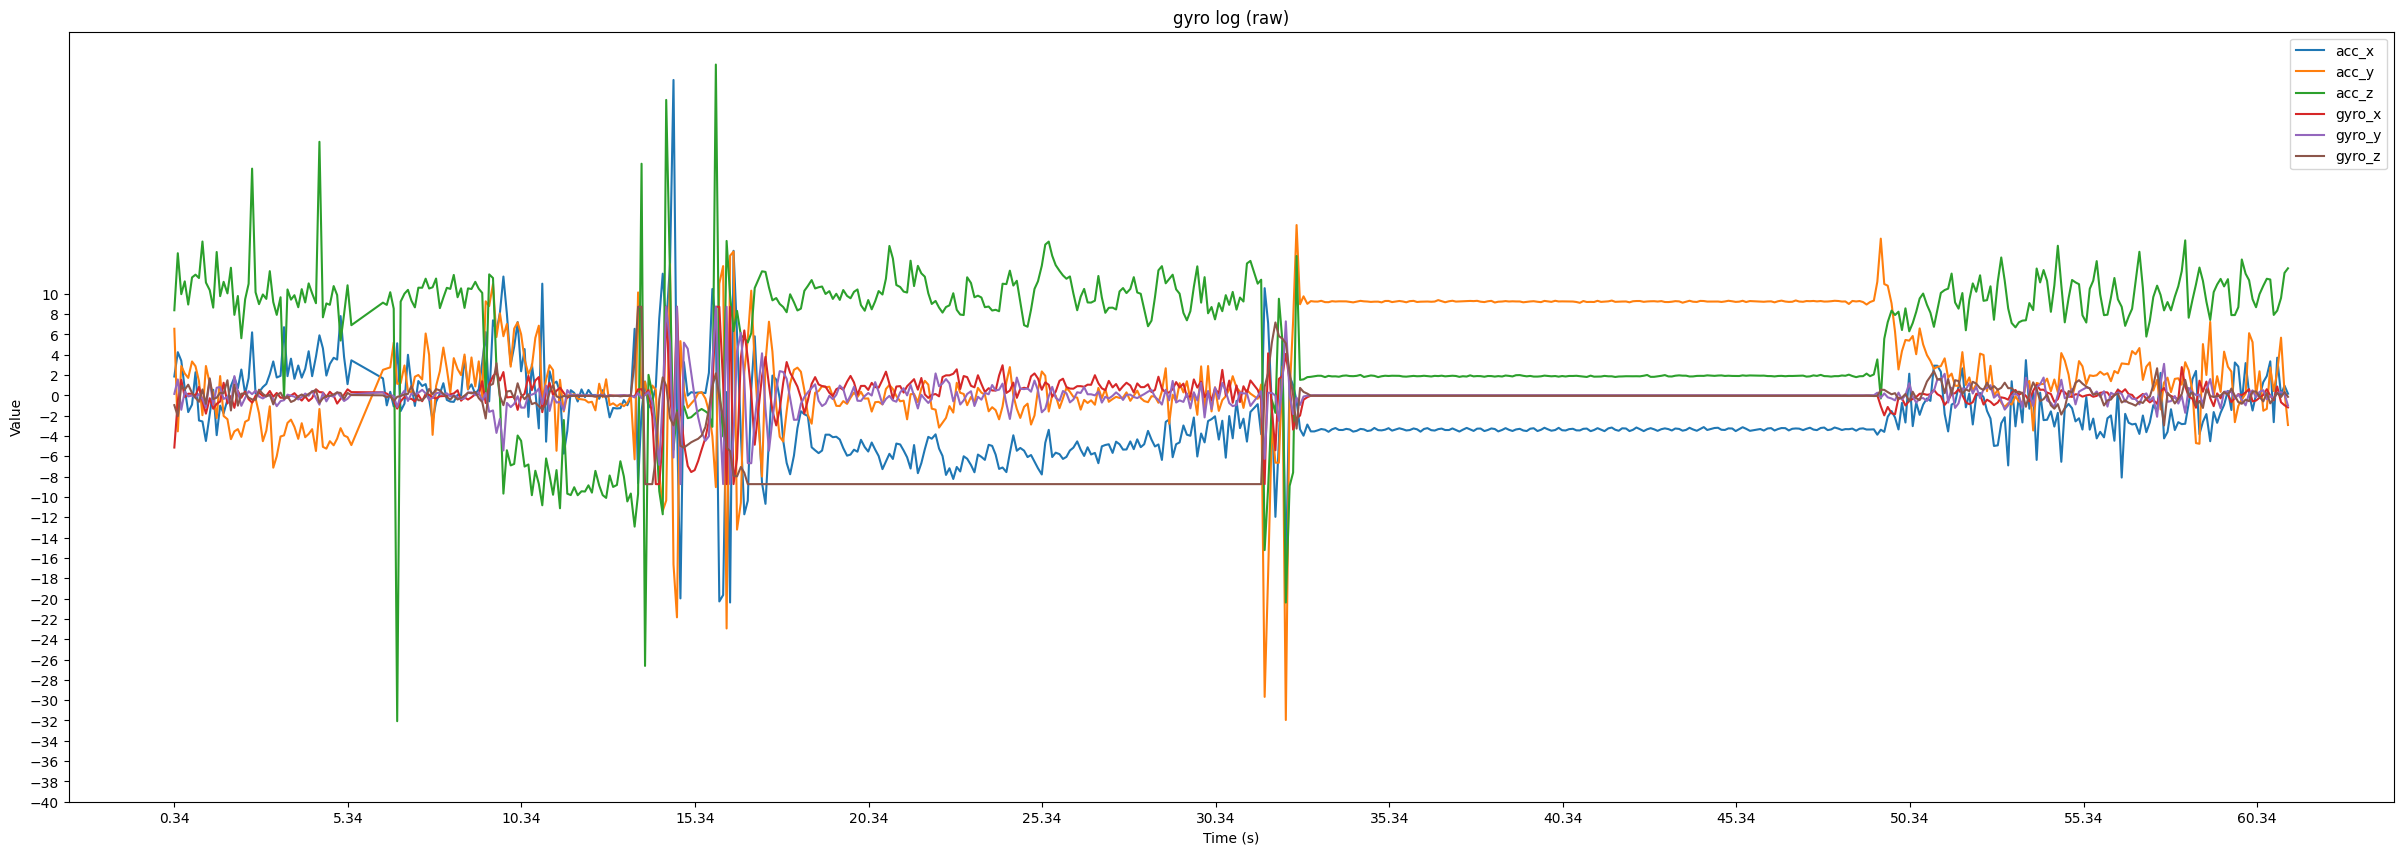

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Convert data to NumPy array for easier manipulation
data = np.array(new_array)

# Define measurement types
measurement_types = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Extract time and measurement columns
time = data[:, 0].astype(float)  # Convert time to float
measurements = data[:, 1:].astype(float)  # Convert measurements to float

# Define the size of the plot (width, height)
plt.figure(figsize=(30, 10))

# Plot each measurement separately
for i in range(measurements.shape[1]):
    plt.plot(time, measurements[:, i], label=f'{measurement_types[i]}')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()

# Set frequency of ticks on x and y axes
plt.xticks(np.arange(min(time), max(time)+1, 5))  # Adjust the step value as needed
plt.yticks(np.arange(-40, 11, 2))  # Adjust the range and step value as needed

# Show plot
plt.title("gyro log (raw)")
plt.show()


### Add filter (Noise reduction)

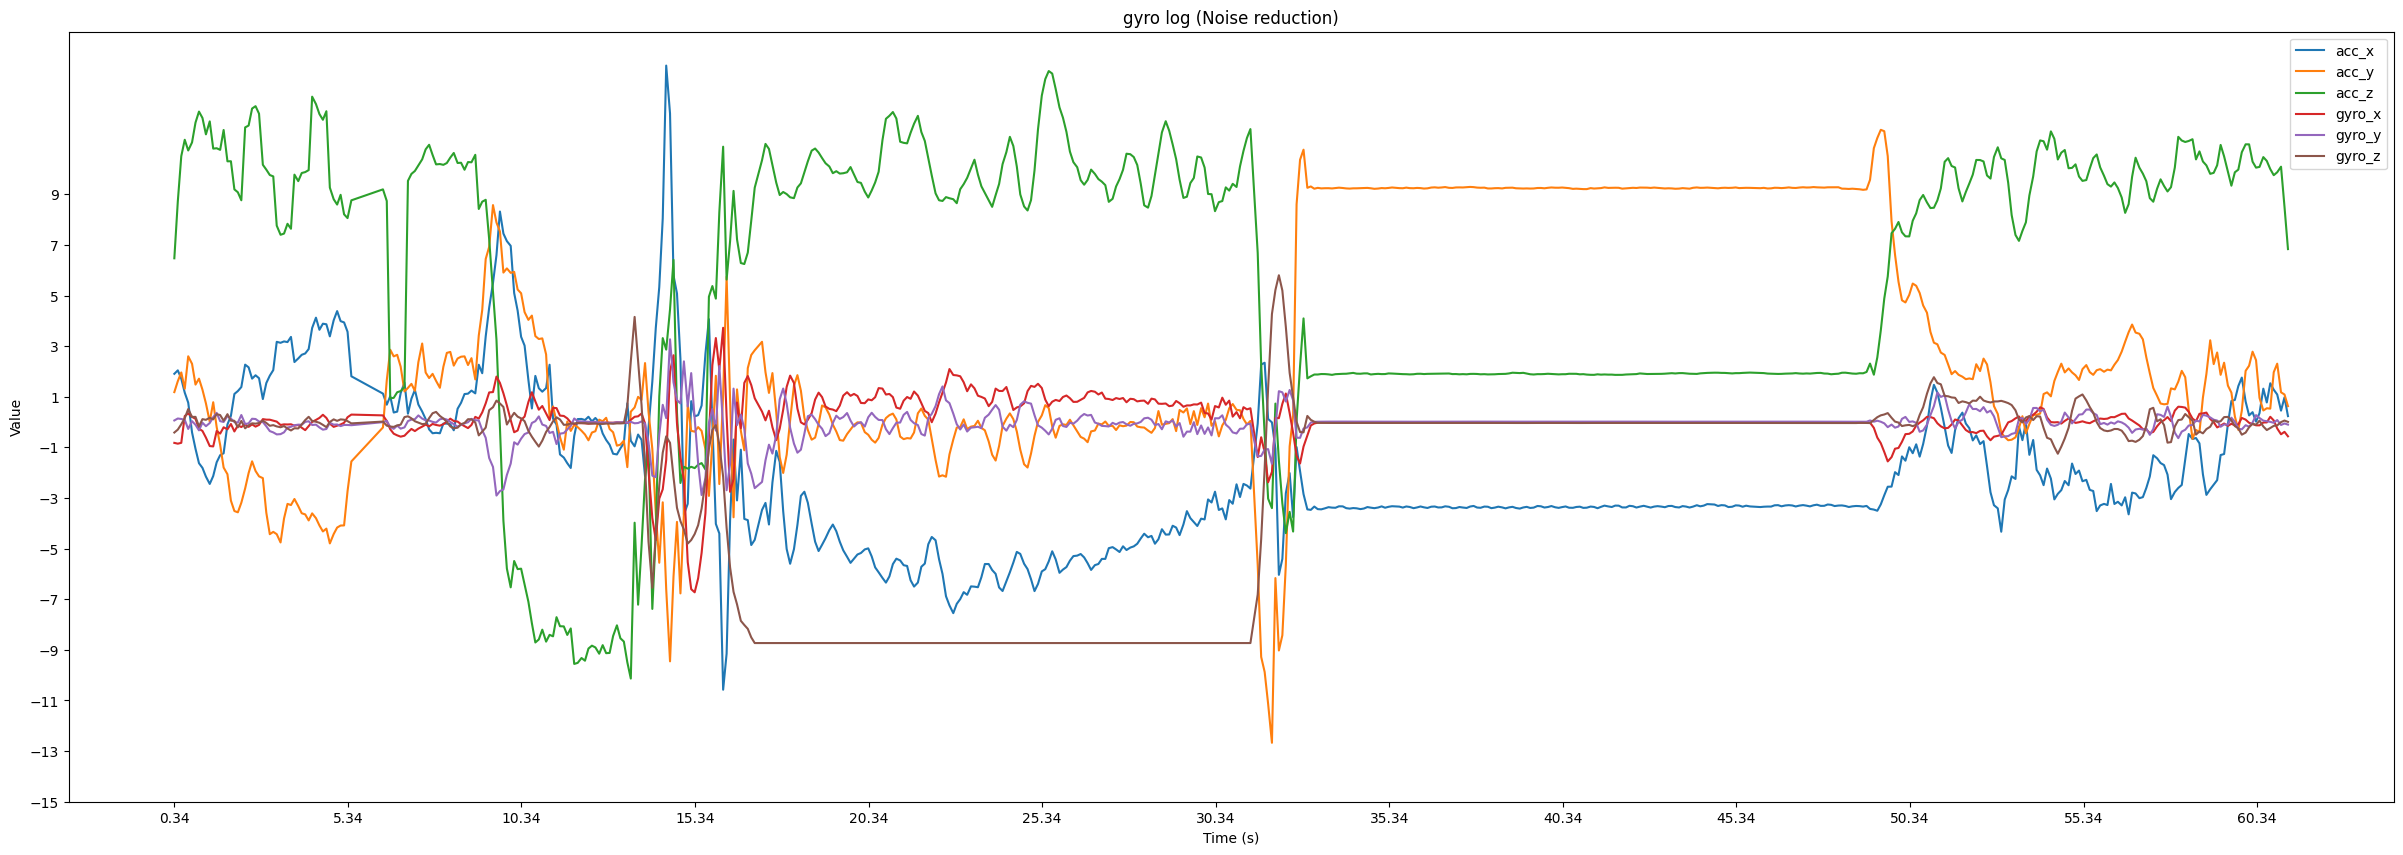

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
import ast

file_path = "/content/GYRO_log_9.txt"

# Open the file in read mode
with open(file_path, 'r') as file:
    # Read the entire contents of the file as a string
    file_contents = file.read()

# Convert the string representation of the array to an actual array using ast.literal_eval
array = ast.literal_eval(file_contents)
new_array= []
for i in range(len(array)):
  new_array.append(array[i][1])

# Define moving average filter function
def moving_average(data, window_size):
    # Define filter kernel
    kernel = np.ones(window_size) / window_size
    # Apply filter
    filtered_data = convolve(data, kernel, mode='same')
    return filtered_data


# Convert data to NumPy array for easier manipulation
data = np.array(new_array)

# Define measurement types
measurement_types = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Extract time and measurement columns
time = data[:, 0].astype(float)  # Convert time to float
measurements = data[:, 1:].astype(float)  # Convert measurements to float

# Apply moving average filter to each measurement
window_size = 5  # Adjust window size as needed
filtered_measurements = np.zeros_like(measurements)
for i in range(measurements.shape[1]):
    filtered_measurements[:, i] = moving_average(measurements[:, i], window_size)

# Define the size of the plot (width, height)
plt.figure(figsize=(30, 10))

# Plot each measurement separately
for i in range(filtered_measurements.shape[1]):
    plt.plot(time, filtered_measurements[:, i], label=f'{measurement_types[i]}')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()

# Set frequency of ticks on x and y axes
plt.xticks(np.arange(min(time), max(time)+1, 5))  # Adjust the step value as needed
plt.yticks(np.arange(-15, 11, 2))  # Adjust the range and step value as needed
plt.title("gyro log (Noise reduction)")
# Show plot
plt.show()


### DEPLOYMENT SIMULATION

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
import ast
import time

file_path = "/content/GYRO_log_9.txt"

# Open the file in read mode
with open(file_path, 'r') as file:
    # Read the entire contents of the file as a string
    file_contents = file.read()

# Convert the string representation of the array to an actual array using ast.literal_eval
array = ast.literal_eval(file_contents)

# Extract sensor readings from the nested lists
normalized_array = []

for entry in array:
    if isinstance(entry, list) and len(entry) == 2:
        timestamp, readings = entry
        if isinstance(readings, list) and len(readings) == 7:
            normalized_array.append(readings)

# Convert to numpy array
data_array = np.array(normalized_array)

# Check the shape of the array to ensure it is two-dimensional
if len(data_array.shape) != 2 or data_array.shape[1] != 7:
    raise ValueError("Data array does not have the expected dimensions")

# Extract the relevant measurement data
measurements = data_array  # Assuming the entire row is needed

# Define moving average filter function
def moving_average(data, window_size):
    # Define filter kernel
    kernel = np.ones(window_size) / window_size
    # Apply filter
    filtered_data = convolve(data, kernel, mode='same')
    return filtered_data

# Real-time moving average filter
class RealTimeMovingAverage:
    def __init__(self, window_size):
        self.window_size = window_size
        self.buffer = []

    def filter(self, new_data):
        self.buffer.append(new_data)
        if len(self.buffer) > self.window_size:
            self.buffer.pop(0)
        filtered_data = np.mean(self.buffer, axis=0)
        return filtered_data

# Deployment Logic
def deploy_in_realtime(measurements, interval=0.1, window_size=5):
    Lunch_threshold = -9.0  # G force threshold from all axis
    Lunch_state = False
    Normal_eject = False
    Emergency_eject = False
    start_time = 0
    emergency_time = 10  # seconds
    normal_eject_delay = 2  # seconds
    Eject_threshold = 5 # sqrt(x**2+y**2)
    # Initialize the real-time moving average filter
    rma_filter = RealTimeMovingAverage(window_size)
    filtered_mem =[]
    for t in range(len(measurements)):
        current_time = t * interval  # Calculate current time based on interval

        # Apply real-time moving average filter
        filtered_data = rma_filter.filter(measurements[t])
        filtered_mem.append(filtered_data)
        acceleration_z = filtered_data[3]  # Assuming z-axis is at index 3
        a_xandy = np.sqrt(filtered_data[1]**2 + filtered_data[2]**2)  # sqrt(ax^2 + ay^2)

        if (acceleration_z <= Lunch_threshold) and (Lunch_state==False):
            Lunch_state = True
            print("LUNCH!!!!!")
            print(acceleration_z)
            start_time = current_time

        if Lunch_state:
            if current_time - start_time > emergency_time:
                Emergency_eject = True
                print(f"Time: {current_time:.2f}s - Emergency Eject")
                break
            elif (a_xandy >= Eject_threshold or acceleration_z>9) and current_time - start_time > normal_eject_delay:
                Normal_eject = True
                print(f"Time: {current_time:.2f}s - Normal Eject")
                print("a_xandy",a_xandy,"acceleration_z",acceleration_z)
                break
            print(f"Time: {current_time:.2f}s, a x&y: {a_xandy:.2f}g")
        else:
          print(f"Time: {current_time:.2f} : nothing")

        # Simulate real-time by sleeping for the interval duration
        time.sleep(interval)
    return filtered_mem

# Simulate real-time deployment
filtered_mem = deploy_in_realtime(measurements, interval=0.1, window_size=5)
measurements = filtered_mem

Time: 0.00 : nothing
Time: 0.10 : nothing
Time: 0.20 : nothing
Time: 0.30 : nothing
Time: 0.40 : nothing
Time: 0.50 : nothing
Time: 0.60 : nothing
Time: 0.70 : nothing
Time: 0.80 : nothing
Time: 0.90 : nothing
Time: 1.00 : nothing
Time: 1.10 : nothing
Time: 1.20 : nothing
Time: 1.30 : nothing
Time: 1.40 : nothing
Time: 1.50 : nothing
Time: 1.60 : nothing
Time: 1.70 : nothing
Time: 1.80 : nothing
Time: 1.90 : nothing
Time: 2.00 : nothing
Time: 2.10 : nothing
Time: 2.20 : nothing
Time: 2.30 : nothing
Time: 2.40 : nothing
Time: 2.50 : nothing
Time: 2.60 : nothing
Time: 2.70 : nothing
Time: 2.80 : nothing
Time: 2.90 : nothing
Time: 3.00 : nothing
Time: 3.10 : nothing
Time: 3.20 : nothing
Time: 3.30 : nothing
Time: 3.40 : nothing
Time: 3.50 : nothing
Time: 3.60 : nothing
Time: 3.70 : nothing
Time: 3.80 : nothing
Time: 3.90 : nothing
Time: 4.00 : nothing
Time: 4.10 : nothing
Time: 4.20 : nothing
Time: 4.30 : nothing
Time: 4.40 : nothing
Time: 4.50 : nothing
Time: 4.60 : nothing
Time: 4.70 : 

## save log graph

In [66]:
measurements = np.array(measurements)

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def plot_measurements(measurements, interval=0.1, save_path=None):
    time = np.arange(0, len(measurements) * interval, interval)
    acc_x = measurements[:, 1]
    acc_y = measurements[:, 2]
    acc_z = measurements[:, 3]
    gyro_x = measurements[:, 4]
    gyro_y = measurements[:, 5]
    gyro_z = measurements[:, 6]

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].plot(time, acc_x)
    axs[0, 0].set_title('Acceleration X')
    axs[0, 0].set_xlabel('Time (s)')
    axs[0, 0].set_ylabel('Value')

    axs[0, 1].plot(time, acc_y)
    axs[0, 1].set_title('Acceleration Y')
    axs[0, 1].set_xlabel('Time (s)')
    axs[0, 1].set_ylabel('Value')

    axs[0, 2].plot(time, acc_z)
    axs[0, 2].set_title('Acceleration Z')
    axs[0, 2].set_xlabel('Time (s)')
    axs[0, 2].set_ylabel('Value')

    axs[1, 0].plot(time, gyro_x)
    axs[1, 0].set_title('Gyroscope X')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Value')

    axs[1, 1].plot(time, gyro_y)
    axs[1, 1].set_title('Gyroscope Y')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].set_ylabel('Value')

    axs[1, 2].plot(time, gyro_z)
    axs[1, 2].set_title('Gyroscope Z')
    axs[1, 2].set_xlabel('Time (s)')
    axs[1, 2].set_ylabel('Value')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)  # Save the figure to the specified path
        print(f"Figure saved to {save_path}")
    else:
        plt.show()


# Specify the path where you want to save the figure
save_path = "/content/measurements_plot.png"

# Call the function with the save_path argument
plot_measurements(measurements, interval=0.1, save_path=save_path)


<IPython.core.display.Javascript object>

Figure saved to /content/measurements_plot.png
